In [ ]:
# gitignore 怎么用， 
# git add.

read me # google drive

opimimor 优化器 SGD 随机梯度下降 最优解

# vscode sync with github 

训练 forward backward 链式法制/求导 更新参数
net.eval()  
# CosineLR = False 预选退火

        #    # Backward pass and optimization
        #     loss.backward()
        #     optimizer.step()
        
        
         

In [1]:
#import library or packages
import torch
import torchvision
from torch.utils.data import DataLoader
import cv2
from nets.resnet import resnet34
from tqdm import tqdm
import torch.nn as nn
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random
import torch.optim as optim

Number of training samples: 184
Number of validation samples: 104

Random sample training data:
Sample 1:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 2:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3
Sample 3:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 4:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 2
Sample 5:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3

Random sample validation data:
Sample 1:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 0
Sample 2:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 3:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 1
Sample 4:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 3
Sample 5:
 - Image shape: torch.Size([3, 224, 224])
 - Label: 0


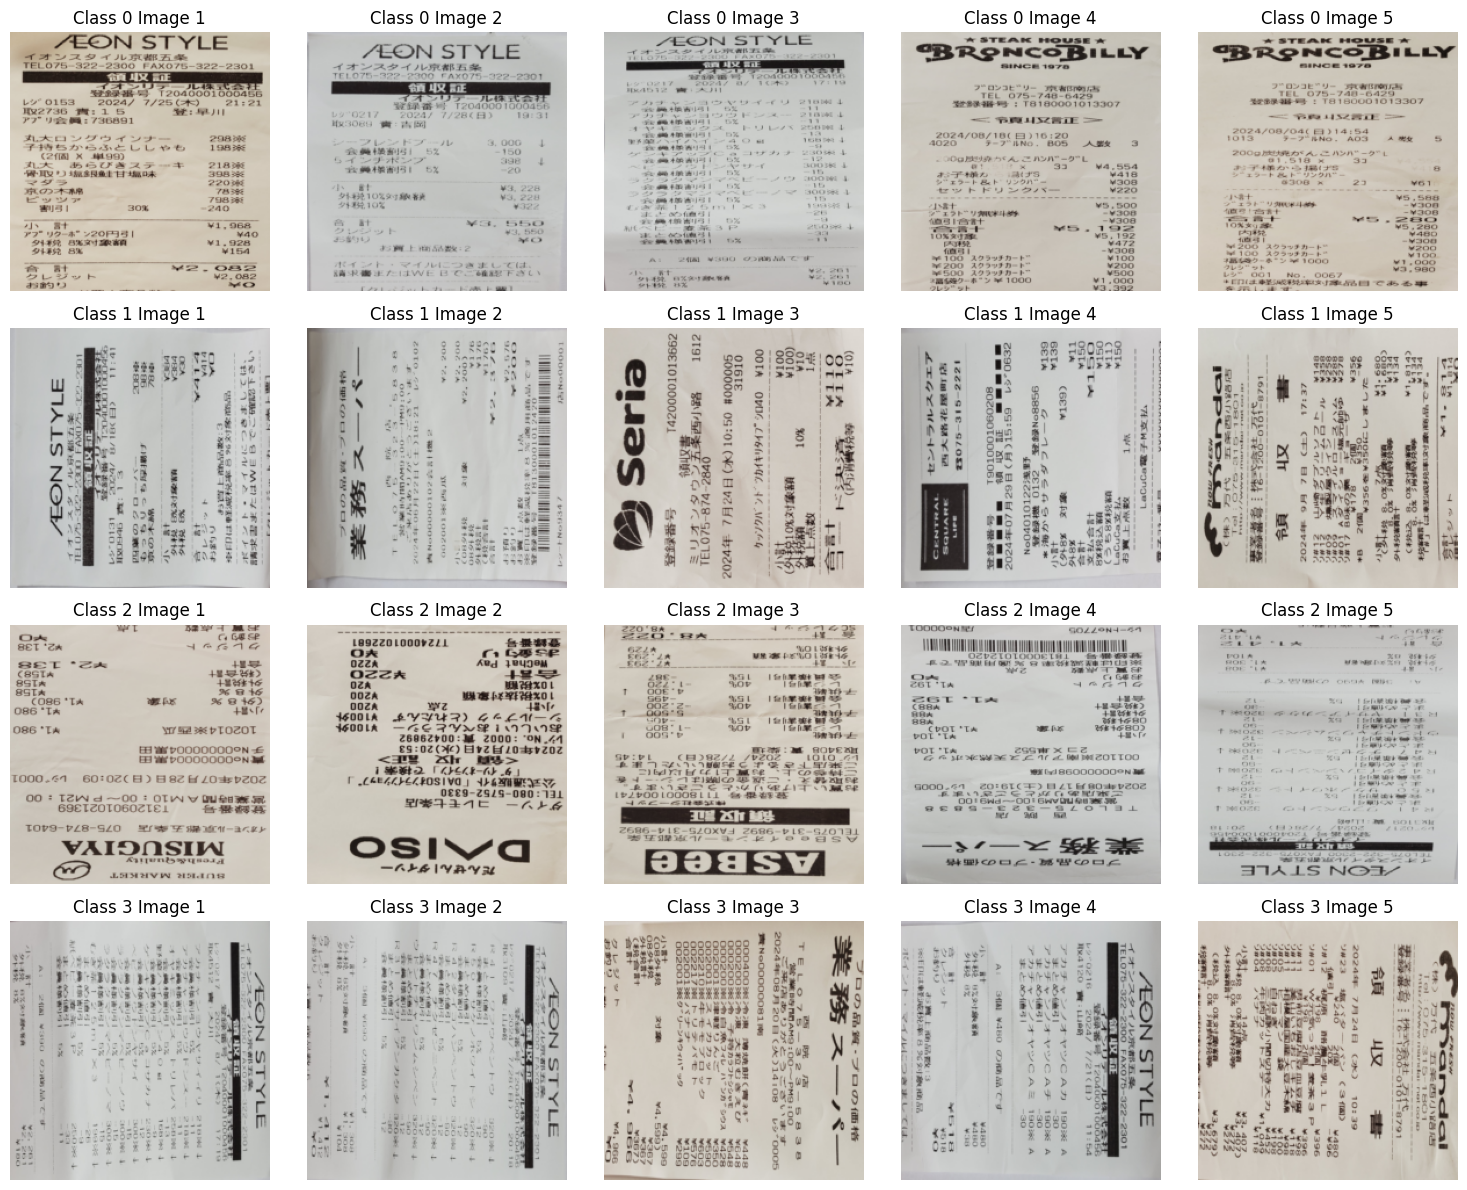

In [3]:
# data load, transdorm and pre plot
from datamodule.dataloader import RotatedReceiptDataset, get_data_transforms
from plotmodule.plot_utils import plot_samples_from_each_class 

# Now you can call the function with any image size
data_transforms = get_data_transforms(image_size=224)

#load the data and Assuming data_transforms is already defined
train_dataset = RotatedReceiptDataset(root_dir='./data/Receipt_data/train/raw', transform=data_transforms['train'])
test_dataset = RotatedReceiptDataset(root_dir='./data/Receipt_data/val/raw', transform=data_transforms['val'])

# Print the length (number of samples) in the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(test_dataset)}")

# Function to print the shape and label of randomly selected images
def print_random_samples(dataset, num_samples=5):
    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Print the details of the randomly selected images
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        print(f"Sample {i + 1}:")
        print(f" - Image shape: {image.shape}")  # Tensor shape: (Channels, Height, Width)
        print(f" - Label: {label}")

# Randomly print 5 images from the training dataset
print("\nRandom sample training data:")
print_random_samples(train_dataset, num_samples=5)

# Randomly print 5 images from the validation dataset
print("\nRandom sample validation data:")
print_random_samples(test_dataset, num_samples=5)   

# Call the function to plot 5 random images from each of the 4 classes in the training dataset
plot_samples_from_each_class(train_dataset, num_samples=5)

In [4]:
from debug_images.debug_utils import save_first_batch_images  # Import the debugging function

# --------------------------------------------------------------------
# Utility Functions
# --------------------------------------------------------------------

# Function to get the current learning rate 
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# --------------------------------------------------------------------
# Training and Validation Loop (Main Function)
# --------------------------------------------------------------------

def fit_one_epoch(net, softmaxloss, epoch, epoch_size, epoch_size_val, gen, gen_test, Epoch, cuda, save_first_batch_images_flag=False):
    """
    Trains and validates the model for one epoch.
    
    Args:
        net: Neural network model.
        softmaxloss: Loss function, typically CrossEntropyLoss.
        epoch: Current epoch number.
        epoch_size: Number of batches in training dataset.
        epoch_size_val: Number of batches in validation dataset.
        gen: Training data DataLoader.
        gen_test: Validation data DataLoader.
        Epoch: Total number of epochs.
        cuda: Whether to use GPU for training.
        save_first_batch_images_flag: Flag to save images from the first batch for debugging.
    """
    # ----------------------------------------------------------------
    # Training Phase
    # ----------------------------------------------------------------
    print('\nStart train')
    net.train()  # Set the model to training mode
    total_loss = 0

    with tqdm(total=epoch_size, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            images, targets = batch[0], batch[1]

            # Move data to GPU if available
            if cuda:
                images = images.cuda()
                targets = targets.cuda()

            # Optionally save the first batch images for debugging
            if save_first_batch_images_flag:
                save_first_batch_images(epoch, iteration, images, targets)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass outputs,_ = net(images)
            outputs= net(images)

            # Handle tuple outputs (if model returns multiple outputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Compute loss
            loss = softmaxloss(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

            # Update progress bar with current total loss and learning rate
            pbar.set_postfix(**{
                'total_loss': float(total_loss / (iteration + 1)),
                'lr': get_lr(optimizer)
            })
            pbar.update(1)

    # ----------------------------------------------------------------
    # Validation Phase
    # ----------------------------------------------------------------
    print('\nStart test')
    net.eval()  # Set the model to evaluation mode
    test_correct = 0  # Variable to track number of correct predictions

    with torch.no_grad():  # Disable gradient computation for validation
        with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
            for iteration, batch in enumerate(gen_test):
                images, targets = batch[0], batch[1]

                # Move data to GPU if available
                if cuda:
                    images = images.cuda()
                    targets = targets.cuda()

                # Forward pass
                outputs = net(images)

                # Handle tuple outputs (if model returns multiple outputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # Get the predicted class (highest score)
                _, predicted = torch.max(outputs, 1)

                # Count number of correct predictions
                test_correct += torch.sum(predicted == targets).item()

                # Update progress bar with test accuracy
                pbar.set_postfix(**{
                    'test AP': float(100 * test_correct / len(gen_test.dataset))
                })
                pbar.update(1)

    # ----------------------------------------------------------------
    # Save Model After Epoch
    # ----------------------------------------------------------------
    torch.save(net.state_dict(), f'logs/Epoch{epoch + 1}-Total_Loss{round(total_loss / epoch_size, 4)}.pth')


# Main script to run training and validation
if __name__ == '__main__':
    # ----------------------------------------------------------------
    # System Setup
    # ----------------------------------------------------------------
    # Automatically detect if CUDA (GPU) is available
    cuda = torch.cuda.is_available()

    # Define training configuration variables
    pre_train = False      # Whether to load a pretrained model
    CosineLR = False       # Whether to use Cosine Annealing LR scheduler
    lr = 1e-3              # Learning rate
    Batch_size = 8         # Batch size for training
    Init_Epoch = 0         # Initial epoch (usually 0)
    Fin_Epoch = 10         # Final epoch (number of epochs to train)

    # ----------------------------------------------------------------
    # Model Creation
    # ----------------------------------------------------------------
    # Create the model (example using ResNet34)
    model = resnet34(num_classes=4)  # Assuming 4 classes

    # Load the pretrained model if needed
    if pre_train:
        model_path = 'logs/resnet50-mnist.pth'  # Path to the pre-trained model
        if cuda:
            model.load_state_dict(torch.load(model_path))
        else:
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Set the device (either GPU or CPU)
    device = torch.device('cuda' if cuda else 'cpu')
    model = model.to(device)

    # ----------------------------------------------------------------
    # Data Loading
    # ----------------------------------------------------------------
    # Assuming `train_dataset` and `test_dataset` are already defined elsewhere
    gen = DataLoader(dataset=train_dataset, batch_size=Batch_size, shuffle=True, num_workers=0)
    gen_test = DataLoader(dataset=test_dataset, batch_size=Batch_size // 2, shuffle=True, num_workers=0)

    epoch_size = len(gen)         # Number of training batches per epoch
    epoch_size_val = len(gen_test)  # Number of validation batches per epoch

    # ----------------------------------------------------------------
    # Loss Function and Optimizer
    # ----------------------------------------------------------------
    # Define the loss function (CrossEntropyLoss for classification)
    softmax_loss = torch.nn.CrossEntropyLoss()

    # Define the optimizer (Adam optimizer in this case)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ----------------------------------------------------------------
    # Learning Rate Scheduler
    # ----------------------------------------------------------------
    # Choose the learning rate scheduler
    if CosineLR:
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-10)
    else:
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.92)

    # ----------------------------------------------------------------
    # Training Loop
    # ----------------------------------------------------------------
    # Loop over the range of epochs
    for epoch in range(Init_Epoch, Fin_Epoch):
        # Train and validate for one epoch
        fit_one_epoch(net=model, 
                      softmaxloss=softmax_loss, 
                      epoch=epoch, 
                      epoch_size=epoch_size,
                      epoch_size_val=epoch_size_val, 
                      gen=gen, 
                      gen_test=gen_test, 
                      Epoch=Fin_Epoch, 
                      cuda=cuda)
        
        # Step the learning rate scheduler
        lr_scheduler.step()




Start train


Epoch 1/10: 100%|██████████| 23/23 [00:30<00:00,  1.33s/it, lr=0.001, total_loss=0.83] 



Start test


Epoch 1/10: 100%|██████████| 26/26 [00:08<00:00,  3.23it/s, test AP=50]  



Start train


Epoch 2/10: 100%|██████████| 23/23 [00:39<00:00,  1.70s/it, lr=0.00092, total_loss=0.272]



Start test


Epoch 2/10: 100%|██████████| 26/26 [00:08<00:00,  3.19it/s, test AP=94.2]



Start train


Epoch 3/10: 100%|██████████| 23/23 [00:29<00:00,  1.28s/it, lr=0.000846, total_loss=0.0833]



Start test


Epoch 3/10: 100%|██████████| 26/26 [00:08<00:00,  2.93it/s, test AP=97.1]



Start train


Epoch 4/10: 100%|██████████| 23/23 [00:43<00:00,  1.90s/it, lr=0.000779, total_loss=0.0734]



Start test


Epoch 4/10: 100%|██████████| 26/26 [00:12<00:00,  2.11it/s, test AP=98.1]



Start train


Epoch 5/10: 100%|██████████| 23/23 [00:40<00:00,  1.74s/it, lr=0.000716, total_loss=0.122]



Start test


Epoch 5/10: 100%|██████████| 26/26 [00:09<00:00,  2.66it/s, test AP=98.1]



Start train


Epoch 6/10: 100%|██████████| 23/23 [00:33<00:00,  1.48s/it, lr=0.000659, total_loss=0.0138]



Start test


Epoch 6/10: 100%|██████████| 26/26 [00:08<00:00,  2.98it/s, test AP=98.1]



Start train


Epoch 7/10: 100%|██████████| 23/23 [00:33<00:00,  1.45s/it, lr=0.000606, total_loss=0.0173] 



Start test


Epoch 7/10: 100%|██████████| 26/26 [00:07<00:00,  3.33it/s, test AP=99]  



Start train


Epoch 8/10: 100%|██████████| 23/23 [00:30<00:00,  1.33s/it, lr=0.000558, total_loss=0.0144]



Start test


Epoch 8/10: 100%|██████████| 26/26 [00:07<00:00,  3.31it/s, test AP=99]  



Start train


Epoch 9/10: 100%|██████████| 23/23 [00:35<00:00,  1.54s/it, lr=0.000513, total_loss=0.00676]



Start test


Epoch 9/10: 100%|██████████| 26/26 [00:08<00:00,  3.21it/s, test AP=99]  



Start train


Epoch 10/10: 100%|██████████| 23/23 [00:35<00:00,  1.55s/it, lr=0.000472, total_loss=0.00727]



Start test


Epoch 10/10: 100%|██████████| 26/26 [00:11<00:00,  2.32it/s, test AP=99]  
